In [1]:
from A2a_rhl72 import *
import matplotlib.pyplot as sp

# Initial Check Demo

# Check Questions

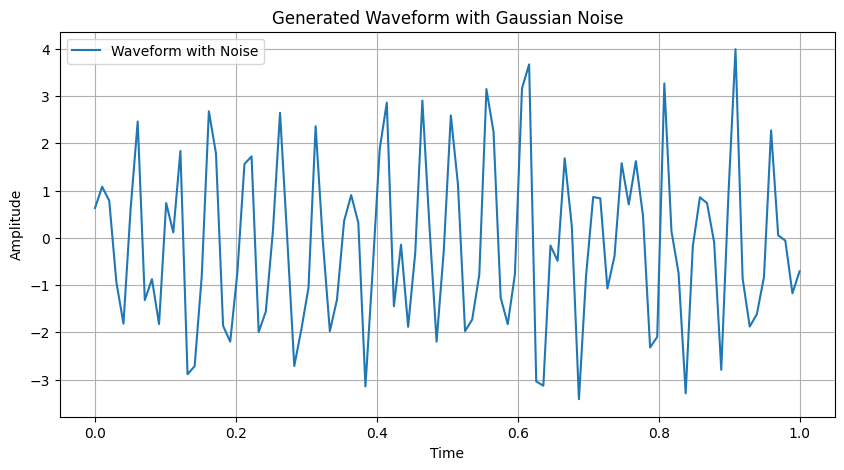

In [2]:
# Generate waveform
t, waveform = genwaveform(N=100, alpha=0.05, A=2, sigma=1, noisetype='Gaussian')

# Plot waveform
plt.figure(figsize=(10, 5))
plt.plot(t, waveform, label="Waveform with Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Generated Waveform with Gaussian Noise")
plt.legend()
plt.grid()
plt.show()


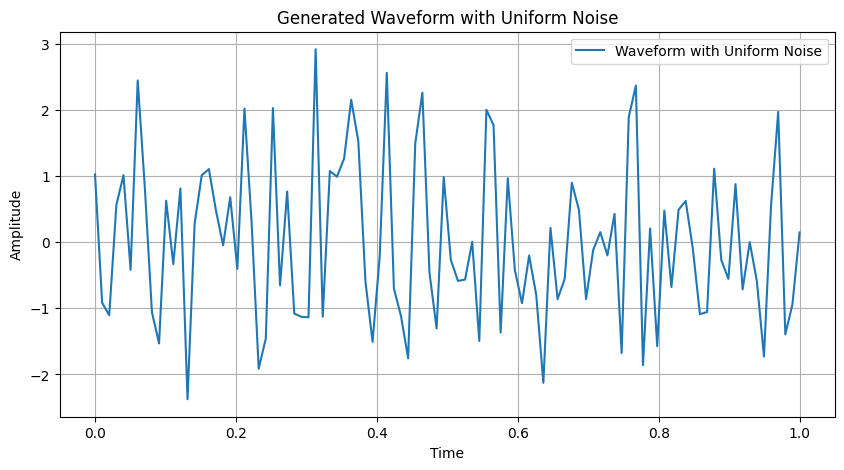

In [3]:
# Generate waveform
t, waveform = genwaveform(N=100, alpha=0.05, A=1, mu=0, sigma=2, noisetype='uniform')

# Plot waveform
plt.figure(figsize=(10, 5))
plt.plot(t, waveform, label="Waveform with Uniform Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Generated Waveform with Uniform Noise")
plt.legend()
plt.grid()
plt.show()


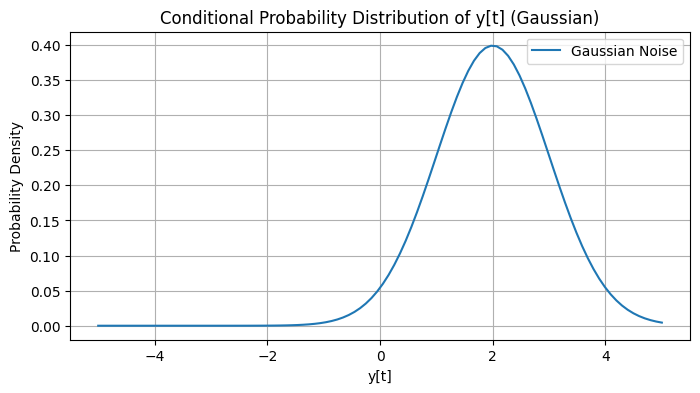

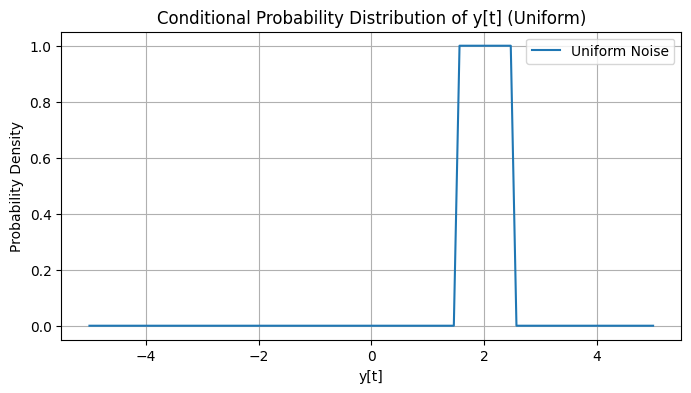

In [4]:
# -------------------------------------------------
# 1c: Notation and Mathematical Expressions
# -------------------------------------------------

def discrete_signal_expression(N=100, A=1, alpha=0.1):
    """
    Generates a discrete-time signal using the delta function representation.

    Parameters
    ----------
    N : int
        Number of samples.
    A : float
        Amplitude of the impulses.
    alpha : float
        Probability of event occurrence.

    Returns
    -------
    x : np.ndarray
        Discrete signal x[t] using delta function.
    event_indices : np.ndarray
        Indices where events occurred.
    """
    x = np.zeros(N)
    event_indices = np.random.choice(range(N), size=int(N * alpha), replace=False)
    x[event_indices] = A
    return x, event_indices

def noise_distribution(noisetype='Gaussian', mu=0, sigma=1, N=100):
    """
    Generates noise samples from a given probability distribution.

    Parameters
    ----------
    noisetype : str
        Type of noise ('Gaussian' or 'Uniform').
    mu : float
        Mean of noise distribution.
    sigma : float
        Standard deviation (Gaussian) or range width (Uniform).
    N : int
        Number of samples.

    Returns
    -------
    noise : np.ndarray
        Noise samples.
    """
    if noisetype == 'Gaussian':
        noise = np.random.normal(mu, sigma, N)
    elif noisetype == 'Uniform':
        noise = np.random.uniform(mu - sigma / 2, mu + sigma / 2, N)
    else:
        raise ValueError("Unsupported noise type. Use 'Gaussian' or 'Uniform'.")
    return noise

# -------------------------------------------------
# 1d: Conditional Probability of the Waveform
# -------------------------------------------------

def conditional_probability_waveform(A=1, mu=0, sigma=1, noisetype='Gaussian'):
    """
    Computes the probability distribution of y[t] given that a signal is present.

    Parameters
    ----------
    A : float
        Amplitude of the signal.
    mu : float
        Mean of noise distribution.
    sigma : float
        Standard deviation of noise.
    noisetype : str
        Type of noise ('Gaussian' or 'Uniform').

    Returns
    -------
    pdf_func : function
        Probability density function of y[t].
    """
    def gaussian_pdf(y, mean, sigma):
        return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((y - mean) ** 2) / (2 * sigma ** 2))

    def uniform_pdf(y, low, high):
        return np.where((y >= low) & (y <= high), 1 / (high - low), 0)

    if noisetype == 'Gaussian':
        return lambda y: gaussian_pdf(y, A + mu, sigma)
    elif noisetype == 'Uniform':
        return lambda y: uniform_pdf(y, A + mu - sigma / 2, A + mu + sigma / 2)
    else:
        raise ValueError("Unsupported noise type. Use 'Gaussian' or 'Uniform'.")

# -------------------------------------------------
# Testing 1c and 1d
# -------------------------------------------------

def plot_conditional_probability(A=1, mu=0, sigma=1, noisetype='Gaussian', y_range=(-5, 5), num_points=100):
    """
    Plots the probability distribution of y[t] given a signal is present.

    Parameters
    ----------
    A : float
        Amplitude of the signal.
    mu : float
        Mean of noise distribution.
    sigma : float
        Standard deviation of noise.
    noisetype : str
        Type of noise ('Gaussian' or 'Uniform').
    y_range : tuple
        Range of y values to plot.
    num_points : int
        Number of points to sample for the plot.

    Returns
    -------
    None
    """
    y_values = np.linspace(y_range[0], y_range[1], num_points)
    pdf_func = conditional_probability_waveform(A, mu, sigma, noisetype)
    probabilities = pdf_func(y_values)

    plt.figure(figsize=(8, 4))
    plt.plot(y_values, probabilities, label=f'{noisetype} Noise')
    plt.xlabel('y[t]')
    plt.ylabel('Probability Density')
    plt.title(f'Conditional Probability Distribution of y[t] ({noisetype})')
    plt.legend()
    plt.grid(True)
    plt.show()



x, events = discrete_signal_expression(N=100, A=2, alpha=0.1)
noise = noise_distribution(noisetype='Gaussian', mu=0, sigma=1, N=100)
plot_conditional_probability(A=2, mu=0, sigma=1, noisetype='Gaussian')
plot_conditional_probability(A=2, mu=0, sigma=1, noisetype='Uniform')


In [5]:
!pip install h5py


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [7]:
from A2a-testdata-zero-based-index.h5 import *

# Compute detection counts using a threshold of 1
counts = detectioncounts(i50, y50, 1)

# Extract and print the number of false positives
print(f"False Positives: {counts.fp}")

SyntaxError: invalid syntax (3978968803.py, line 1)

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
with h5py.File("A2a-testdata.h5", "r") as f:
    y50 = np.array(f["y50"])  # Load waveform data
    i50 = np.array(f["i50"])  # Load event indices

# Set threshold
threshold = 1.0

# Compute detection counts
counts = detectioncounts(i50, y50, threshold)

# Print results
print(f"True Positives (TP): {counts.tp}")
print(f"False Negatives (FN): {counts.fn}")
print(f"False Positives (FP): {counts.fp}")
print(f"True Negatives (TN): {counts.tn}")

# Plot detections (Question 2b Example)
plot_detections(y50, i50, threshold, title="Detections from A2a-testdata.h5")
